In [1]:
#Packages for dataframe manipulation, calculations, and visualizations
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys

#Packages for natural language processing
import nltk
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import TruncatedSVD

#Updating default settings
pd.set_option('display.max_columns', 1000)

In [2]:
#Importing the data set 
dataset = pd.read_pickle('other_xmltodict_all_major_fields.pkl')

#Drop the rows with no values in section_bodies
dataset = dataset[dataset['section_bodies'] != 'Null']

#Do not include SI regs in the analysis, as stated in the RFP scope
dataset = dataset[dataset['regulation_type']!= 'SI']

## 1. Creating the Corpus & Sparse Matrix

In [3]:
def make_corpus(dataset, column):
    '''This function reads in a pandas dataframe (dataset) and the column name (e.g. 'text_column'). 
    Then it strips all punctuation, makes it lower case, tokenizes it, and removes english stopwords. 
    Finally it returns two lists (either directly or via tuple unpacking. the first is the documents
    without stopwords; the second is the documents stemmed via porterstemmer.
    '''
    from nltk.corpus import stopwords
    from nltk.tokenize import word_tokenize
    stop_words = set(stopwords.words('english'))
    import string 
    import sys
    translator = str.maketrans('', '', string.punctuation)
    import re
    from nltk.stem import PorterStemmer
    ps = PorterStemmer()
    filtered_text_list = []
    stemmed_text_list = []
    for i in range (0, len(dataset)):
        text = dataset.iloc[i][column].lower().translate(translator)
        text = re.sub('\n', ' ', text)
        word_tokens = word_tokenize(text) 
        filtered_text = [w for w in word_tokens if not w in stop_words]
        filtered_text = []
        for w in word_tokens:
            if w not in stop_words:
                filtered_text.append(w)
        stemmed_text = []
        for w in filtered_text:
            stemmed_text.append(ps.stem(w))
        filtered_text_list.append(str(filtered_text).translate(translator))
        stemmed_text_list.append(str(stemmed_text).translate(translator))
        #sys.stdout.write("\r" + "Creating Corpus.. Processing Record: " + str(i+1) + " of " + str(len(dataset)))
        #sys.stdout.flush()
    #print("\nDONE!")
    return filtered_text_list, stemmed_text_list

In [4]:
filtered_text, stemmed_text = make_corpus(dataset,'section_bodies')

In [5]:
cv = CountVectorizer()
X = cv.fit_transform(stemmed_text).toarray()
df_sparse = pd.DataFrame(X, columns = cv.get_feature_names())

## 2. Cleaning the Sparse Matrix

##### Removing features which contain a number

In [6]:
def hasNumbers(inputString):
    return any(char.isdigit() for char in inputString)

#remove all the features which are numeric
features = pd.Series(df_sparse.columns)
index = features.map(hasNumbers)

In [7]:
#how many are numeric?
index.value_counts()

False    7512
True     5083
dtype: int64

In [8]:
#list of features to drop
dropped_features = features[index]

#Drop it like its hot
df_sparse = df_sparse.drop(columns=dropped_features)

##### Removing the helping verbs

In [9]:
from nltk.stem import PorterStemmer
ps = PorterStemmer()

In [10]:
#There are 23 helping verbs in total
helping_verbs = ['am', 'is', 'are', 'was', 'were', 'being', 'been', 'be', 'have', 'has', 'had', 'do', 'does', 
                 'did', 'will', 'would', 'shall', 'should', 'may', 'might', 'must', 'can', 'could']

#Obtain the stemed version of each word
helping_verbs_stemmed = []
for verb in helping_verbs:
    helping_verbs_stemmed.append(ps.stem(verb).lower())

In [11]:
#Which helping verbs are in the sparse matrix?
helping_verbs_stemmed_drop = []

cols = list(df_sparse.columns)

for verb in helping_verbs_stemmed:
    if verb in cols:
        helping_verbs_stemmed_drop.append(verb)
        
print (helping_verbs_stemmed_drop)

['will', 'would', 'shall', 'may', 'might', 'must', 'could']


In [12]:
#Remove the helping verbs and check the outcomes
print ('shape before dropping helping verbs:' + str(df_sparse.shape))

df_sparse = df_sparse.drop(columns=helping_verbs_stemmed_drop)

print ('shape after dropping helping verbs:' + str(df_sparse.shape))

shape before dropping helping verbs:(2274, 7512)
shape after dropping helping verbs:(2274, 7505)


## 3. TF-IDF Vectorizer

In [13]:
#convert the count matrix to tf-idf representation
transformer = TfidfTransformer()
tfidf = transformer.fit_transform(df_sparse).toarray()

In [14]:
feature_names = df_sparse.columns

# find maximum value for each of the features over all of dataset:
max_val = df_sparse.max(axis=0).ravel()

#sort weights from smallest to biggest and extract their indices 
sort_by_tfidf = max_val.argsort()

print("Features with lowest tfidf:\n{}".format(
      feature_names[sort_by_tfidf[:20]]))

print("\nFeatures with highest tfidf: \n{}".format(
      feature_names[sort_by_tfidf[-20:]]))

Features with lowest tfidf:
Index(['northwestel', 'speech', 'premiumpay', 'spednic', 'spectat',
       'discredit', 'prepaidport', 'discriminatori', 'sphere', 'iran', 'ipc',
       'ioniz', 'ionexchang', 'dish', 'dishonest', 'sovereignti', 'ioc',
       'sparkler', 'discomfort', 'discolor'],
      dtype='object')

Features with highest tfidf: 
Index(['appeal', 'particular', 'system', 'categori', 'licenc', 'produc',
       'hazard', 'act', 'particip', 'certif', 'ferri', 'store', 'vessel',
       'subsect', 'dive', 'suppli', 'invest', 'food', 'plan', 'explos'],
      dtype='object')


## 4. Latent Semantic Analysis

In [15]:
#It is reccomended in the SVD python documentation to use n_components as 100 for LSA
## http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html

lsa = TruncatedSVD(n_components = 100, algorithm='arpack', random_state=0)
dtm_lsa = lsa.fit_transform(tfidf)

In [16]:
#What are the top components of each concept?
for i, comp in enumerate(lsa.components_):
    terms_in_comp = zip(cols,comp)
    sorted_terms = sorted(terms_in_comp, key=lambda x: x[1], reverse=True)[:10]
    print('Concept %d:' %i)
    
    for term in sorted_terms:
        print(term[0])
    print (' ')
    

Concept 0:
forbid
come
datum
regi
registrar
lamproom
optim
nwtsoirc
secretari
perpendicular
 
Concept 1:
lamproom
nwtsoirc
plywood
element
airport
build
stripe
appli
grown
oviduct
 
Concept 2:
board
act
perpendicular
subrul
marker
commod
author
poult
secretari
purg
 
Concept 3:
board
commod
marker
poult
exempt
protrud
interpret
tp
optim
exponentialtimeaverag
 
Concept 4:
immov
prisonerofwar
articl
convent
remarri
canada
ordinari
optim
extens
grandpar
 
Concept 5:
remarri
grandpar
gone
implic
condit
optim
custodian
pave
paddleboat
dustproof
 
Concept 6:
compani
bank
entireti
remarri
hoist
grandpar
insul
invert
acquir
subsidiari
 
Concept 7:
gone
station
canada
implic
registrar
chapter
exponentialtimeaverag
come
forbid
enabl
 
Concept 8:
permafrost
exponentialtimeaverag
gone
author
regi
implic
optim
compani
scare
bank
 
Concept 9:
insul
proclaim
miner
loadcarri
lever
applic
board
lend
compani
prioriti
 
Concept 10:
column
servant
scare
proclaim
lever
italic
amount
paus
font
pave
 
Concep

In [17]:
#Creating a dataframe of the regulations and their concept values
list_concepts = []
    
for i in range(0,len(lsa.components_)):
    list_concepts.append('Concept %d' %i)
    
df_lsa = pd.DataFrame(dtm_lsa, columns=list_concepts)

###### Document Similarity using LSA -> Correlation Matrix

In [18]:
#Create the correlation matrix
## For further details --> http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.219.4988&rep=rep1&type=pdf

df_norm = Normalizer(copy=False).fit_transform(dtm_lsa)
similarity = np.asarray(np.asmatrix(df_norm) * np.asmatrix(df_norm).T)
regs = list(dataset['instrument_number'])
df_heatmap = pd.DataFrame(similarity,index=regs, columns=regs)

## 5. Extracting the highly similar documents

In [19]:
#minimum score/value for regulations to be considered similar
thresh_min = 0.95

#max score/value, above which regulations are the same document
thresh_max = 0.999999

In [20]:
#column names 
regs = df_heatmap.columns

#master list of similar regs to append to
similar_regs = []
score_tracker = []

#analyze each column's scores one at a time
for reg_1 in regs:
    reg_1_scores = df_heatmap[reg_1]
    index_value = 0

    for score in reg_1_scores:
        if (score > thresh_min and score < thresh_max):
            reg_2 = df_heatmap.index[index_value]
            
            #track the reg pairs which exceed the criteria - check for duplicates
            if [reg_2,reg_1] not in similar_regs:
                similar_regs.append([reg_1,reg_2])
                score_tracker.append(score)
                
        index_value += 1


##### Checking the outputs

Given that the formula for the number of possible cominations where order doesn't matter: C(n,r)=n!/(n−r)!r!

In [21]:
comb = int(math.factorial(len(df_heatmap))/(math.factorial((len(df_heatmap)-2))*math.factorial(2)))
print ('total combinations is: ' + str(comb))
print ('Number of reg pairs over the threshold: ' + str(len(similar_regs)))
print ('Percent of reg pairs over the threshold: ' + str(len(similar_regs)/comb*100) + '%')

total combinations is: 2584401
Number of reg pairs over the threshold: 4880
Percent of reg pairs over the threshold: 0.18882518618434213%


##### Finding all regulations 'pairs' 

In [22]:
#convert the nested list into a DataFrame
reg_1 = []
reg_2 = []
corr = []

for pair in similar_regs:
    reg_1.append(pair[0])
    reg_2.append(pair[1])
   
d = {'Reg_1':reg_1, 'Reg_2':reg_2, 'Reg_Score': score_tracker}    
df_similar = pd.DataFrame(data=d)

##### Analyzing How Many Times a Reg Exceeds the Similarity Threshold

In [23]:
#Create single list of all similar reg pairs
regs_above_thres = []
regs_above_thres.extend(reg_1)
regs_above_thres.extend(reg_2)

In [24]:
#Convert to DataFrame & Count Freqnecy of reg occurance 
df_regs_above_thres = pd.DataFrame(data={'Reg_Title':regs_above_thres})
df_regs_above_thres_count = pd.DataFrame(df_regs_above_thres['Reg_Title'].value_counts()).reset_index()
df_regs_above_thres_count.rename(columns={'index':'Reg','Reg_Title':'Count'}, inplace=True)

In [25]:
df_regs_above_thres_count

,Reg,Count
0,"C.R.C., c. 81",88
1,SOR/87-706,87
2,SOR/96-133,87
3,SOR/95-495,87
4,SOR/88-509,87
5,SOR/93-409,85
6,SOR/93-408,85
7,SOR/93-410,85
8,SOR/87-453,83
9,SOR/87-100,83


(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177

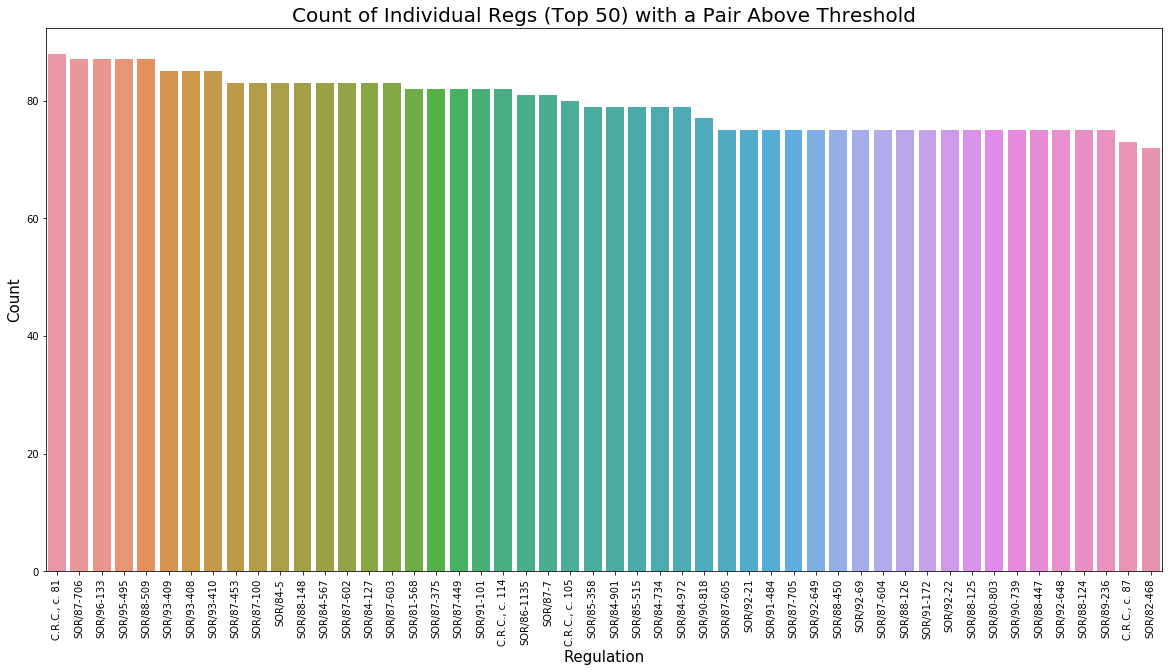

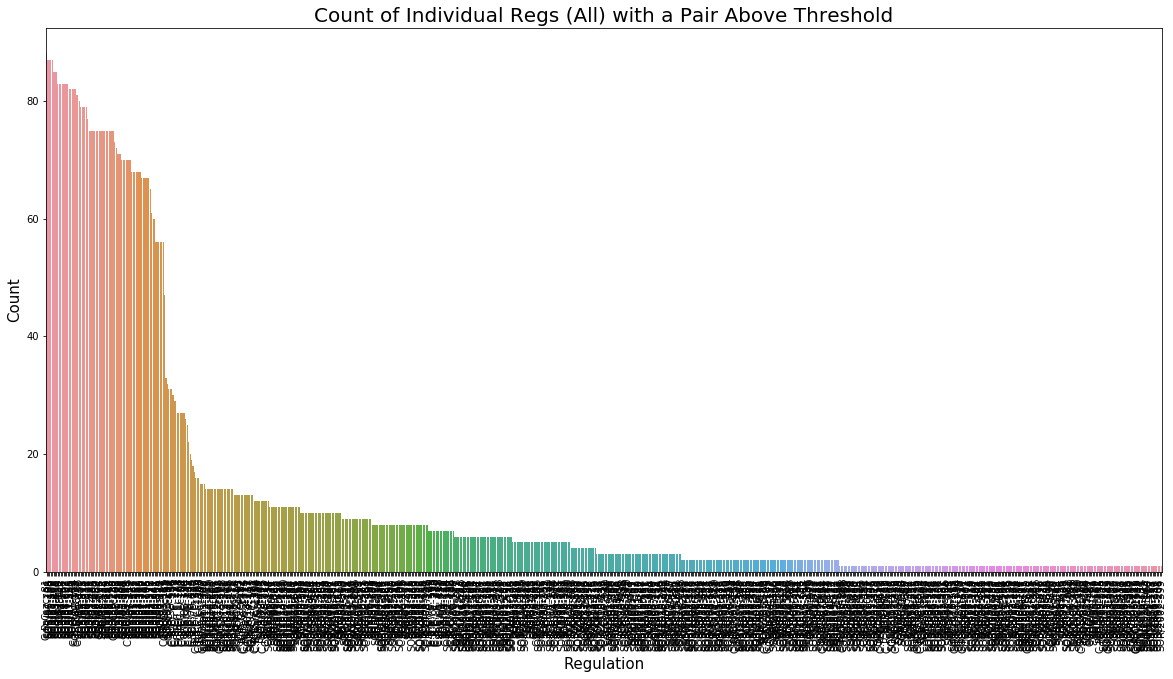

In [26]:
'''
#Visualizing the results 
n = 50
fig, ax = plt.subplots(figsize=(20,10))
sns.barplot(x='Reg',y='Count',data=df_regs_above_thres_count.head(50))
ax.set_title('Count of Individual Regs (Top ' + str(n) + ') with a Pair Above Threshold', size=20)
ax.set_xlabel('Regulation', size=15)
ax.set_ylabel('Count', size=15)
plt.xticks(rotation=90)

fig, ax = plt.subplots(figsize=(20,10))
sns.barplot(x='Reg',y='Count',data=df_regs_above_thres_count)
ax.set_title('Count of Individual Regs (All) with a Pair Above Threshold', size=20)
ax.set_xlabel('Regulation', size=15)
ax.set_ylabel('Count', size=15)
plt.xticks(rotation=90)
'''


In [27]:
#How many 'groups' of similar Regs are there?
len(df_similar['Reg_1'].unique())

578

In [28]:
df_similar

,Reg_1,Reg_2,Reg_Score
0,SOR/93-293,SOR/93-522,0.966448
1,SOR/93-293,SOR/2002-138,0.964432
2,SOR/93-293,SOR/95-558,0.999695
3,SOR/93-293,SOR/78-771,0.957807
4,SOR/93-293,SOR/93-524,0.961989
5,SOR/93-293,"C.R.C., c. 83",0.986880
6,SOR/93-293,SOR/87-706,0.950782
7,SOR/93-293,SOR/93-74,0.961989
8,SOR/93-293,SOR/80-803,0.960127
9,SOR/93-293,SOR/93-409,0.952718


## 6. Creating the Master Excel

In [191]:
#Initalizing the columns
Reg_A = []
Reg_B = []
Reg_Sim_Score = []
Label_A = []
Text_A = []
Label_B = []
Text_B = []
Label_Sim_Score = []

#Iterate through every similar document pair, track the errors
exception_lsa = []
exception_heatmap = []
reg1_xml_flag = []
reg2_xml_flag = []

for row in range(0,len(df_similar)):
    
    #----------------------------- Part 1: Preparing the Reg Lbels ---------------------------------------
   
    #Set the target regs to compare
    reg1 = df_similar['Reg_1'][row]
    reg2 = df_similar['Reg_2'][row]
    reg_overall_corr = df_similar['Reg_Score'][row]

    #Locate the target regs from the dataframe
    df_reg1 = dataset[dataset['instrument_number']==reg1]
    df_reg2 = dataset[dataset['instrument_number']==reg2]

    #Extract the body text from both regs
    reg1_body = list(df_reg1['section_bodies'])
    reg2_body = list(df_reg2['section_bodies'])

    #Extract all the text between singular quotes because each set of quoates is a new section (or subsection) 
    quoted  = re.compile("'[^']*'")
    reg1_body_clean = []
    reg2_body_clean = []

    for section in quoted.findall(str(reg1_body)):
        reg1_body_clean.append(section.strip("'"))

    for section in quoted.findall(str(reg2_body)):
        reg2_body_clean.append(section.strip("'"))

    #Extract the labels from both regs
    reg1_labels = list(df_reg1['section_labels'])
    reg2_labels = list(df_reg2['section_labels'])

    #Extract the section labels for each regs body (note the values are also stored between quotes)
    reg1_labels_clean = []
    reg2_labels_clean = []

    for num in quoted.findall(str(reg1_labels)):
        reg1_labels_clean.append(reg1 + ' Label: ' + num.strip("'"))

    for num in quoted.findall(str(reg2_labels)):
        reg2_labels_clean.append(reg2 + ' Label: ' + num.strip("'"))

    #Checking for and handling xml files with inconsistently labelling
    if len(reg1_labels_clean) != len(reg1_body_clean):
        reg1_xml_flag.append(reg1)

        #If this is the case, then manually create the labels for the regulation
        reg1_labels_clean = []
        for l in range(2,(len(reg1_body_clean)+2)):
            reg1_labels_clean.append(reg1 + ' Label: ' + str(l))

    if len(reg2_labels_clean) != len(reg2_body_clean):
        reg2_xml_flag.append(reg2)

        #If this is the case, then manually create the labels for the regulation
        reg2_labels_clean = []
        for l in range(2,(len(reg2_body_clean)+2)):
            reg2_labels_clean.append(reg2 + ' Label: ' + str(l))  

    #Combine the body and label lists and convert to a dataframe 
    combined_body = []
    combined_body.extend(reg1_body_clean)
    combined_body.extend(reg2_body_clean)

    combined_labels = []
    combined_labels.extend(reg1_labels_clean)
    combined_labels.extend(reg2_labels_clean)

    #The final labelled dataframe - Reg Label and respective text
    df_similar_regs_label = pd.DataFrame(data={'Reg_Label':combined_labels, 'Text':combined_body})

    #There are instances where a label only contains the phrase 'In these Regualtions,'. Drop such rows. 
    df_similar_regs_label = df_similar_regs_label[df_similar_regs_label['Text'] != 'In these Regulations,']

    
    #----------------------------- Part 2: Corpus Creation, TFIDF, and LSA  ---------------------------------------

    #Apply the corpus creating function
    filtered_text_label, stemmed_text_label = make_corpus(df_similar_regs_label,'Text')

    #Create the initial sparse matrix
    cv_label = CountVectorizer()
    X_label = cv_label.fit_transform(stemmed_text_label).toarray()
    df_sparse_label = pd.DataFrame(X_label, columns = cv_label.get_feature_names())

    #Words in the corpus
    features_label = pd.Series(df_sparse_label.columns)

    #Apply the has number function to see which features are numeric (true or false)
    index_label = features_label.map(hasNumbers)

    #Create a list of the features which are numeric ('True')
    dropped_features_label = features_label[index_label]

    #Drop the numeric features
    df_sparse_label = df_sparse_label.drop(columns=dropped_features_label)

    #Apply TF-IDF Weighting
    transformer_label = TfidfTransformer()
    tfidf_label = transformer_label.fit_transform(df_sparse_label).toarray()

    try:
        #Document similarity using LSA
        lsa_label = TruncatedSVD(n_components = 2, algorithm='arpack', random_state=0)
        dtm_lsa_label = lsa_label.fit_transform(tfidf_label)

        #Creating the LSA dataframe 
        list_concepts_label = []

        for i in range(0,len(lsa_label.components_)):
            list_concepts_label.append('Concept %d' %i)

        df_lsa_label = pd.DataFrame(dtm_lsa_label, columns=list_concepts_label)

     
        try:
          #----------------------------- Part 3: Heatmap Score Extraction  ---------------------------------------

            #Normalize the results [0,1] for interpretability of the scores 
            df_norm_label = Normalizer(copy=False).fit_transform(dtm_lsa_label)

            #create the 'heatmap' dataframe for comparing individual labels
            similarity_label = np.asarray(np.asmatrix(df_norm_label) * np.asmatrix(df_norm_label).T)
            regs_label = list(df_similar_regs_label['Reg_Label'])
            df_heatmap_label = pd.DataFrame(similarity_label,index=regs_label, columns=regs_label)

            #Iterate through all the columns and rows of the heat map, only append scores between regs (not within the same reg)
            col_labels = list(df_heatmap_label.columns)
            index_labels = list(df_heatmap_label.index)

            for i in range (0,len(col_labels)):
                col_title = col_labels[i].split()[0]

                for j in range (0,len(index_labels)):
                    index_title = df_heatmap_label.index[j].split()[0]

                    if col_title != index_title:
                        Reg_A.append(col_title)
                        Reg_B.append(index_title)
                        Reg_Sim_Score.append(round(reg_overall_corr,4))
                        Label_A.append(col_labels[i])
                        Label_B.append(index_labels[j])
                        Text_A.append(str(list(df_similar_regs_label[df_similar_regs_label['Reg_Label']==col_labels[i]]['Text'])).strip("'[]"))
                        Text_B.append(str(list(df_similar_regs_label[df_similar_regs_label['Reg_Label']==index_labels[j]]['Text'])).strip("'[]"))
                        Label_Sim_Score.append(df_heatmap_label.loc[index_labels[j],col_labels[i]])
        
        #Track the heatmap errors
        except:
            exception_heatmap.append(row)
            
    #Track the LSA creation errors  
    except:
        exception_lsa.append(row)

    #Tracking how long this loop will take...
    sys.stdout.write("\r" + "Creating the master correlation matrix.. Processing Record: " + str(row+1) + " of " + str(len(df_similar)))
    sys.stdout.flush()
print("\nDONE!")

Creating the master correlation matrix.. Processing Record: 4880 of 4880
DONE!


In [192]:
#Check lengths of all lists
print (len(Reg_A))
print (len(Reg_B))
print (len(Reg_Sim_Score))
print (len(Label_A))
print (len(Label_B))
print (len(Text_A))
print (len(Text_B))
print (len(Label_Sim_Score))

3935182
3935182
3935182
3935182
3935182
3935182
3935182
3935182


In [177]:
#Initalizing the columns
Reg_A = []
Reg_B = []
Reg_Sim_Score = []
Label_A = []
Text_A = []
Label_B = []
Text_B = []
Label_Sim_Score = []

#Iterate through all the columns and rows of the heat map, only append scores between regs (not within the same reg)
col_labels = list(df_heatmap_label.columns)
index_labels = list(df_heatmap_label.index)

for i in range (0,len(col_labels)):
    col_title = col_labels[i].split()[0]

    for j in range (0,len(index_labels)):
        index_title = df_heatmap_label.index[j].split()[0]

        if col_title != index_title:
            Reg_A.append(col_title)
            Reg_B.append(index_title)
            Reg_Sim_Score.append(round(reg_overall_corr,4))
            Label_A.append(col_labels[i])
            Label_B.append(index_labels[j])
            Text_A.append(str(list(df_similar_regs_label[df_similar_regs_label['Reg_Label']==col_labels[i]]['Text'])).strip("'[]"))
            Text_B.append(str(list(df_similar_regs_label[df_similar_regs_label['Reg_Label']==index_labels[j]]['Text'])).strip("'[]"))
            #Label_Sim_Score.append(df_heatmap_label.at[col_labels[i], df_heatmap_label.index[j]]) 
            Label_Sim_Score.append(df_heatmap_label.loc[index_labels[j],col_labels[i]])

###### Creating the final dataframe and exporting to excel for analysis

In [193]:
d = {'Reg_A':Reg_A, 'Reg_B':Reg_B, 'Reg_Sim_Score':Reg_Sim_Score, 'Label_A':Label_A, 'Text_Label_A': Text_A,
     'Label_B':Label_B, 'Text_Label_B':Text_B, 'Label_Sim_Score':Label_Sim_Score}

df_top = pd.DataFrame(data=d)

In [194]:
df_top.to_excel('LSA_Reg_Label_Matrix_Top95_v1.xlsx')

In [218]:
len(exceptions)


10860

# Exceptions Checking

In [138]:
i = 268
df_similar.iloc[i:i+1]

,Reg_1,Reg_2,Reg_Score
268,SOR/99-384,SOR/2007-201,0.952057
